## NB

Only install fiftyone **after** the devcontainer was created.

This ensures that the required mongodb gets created

In [35]:
# erase folder ˜/fiftyone/open-images-v7
import os
os.system('rm -rf ~/fiftyone/open-images-v7')




0

In [ ]:
import os
import fiftyone as fo
import fiftyone.zoo as foz

TargetLabel = "Coffee cup"
TargetImages = 50

try:
    # Load the dataset
    foz.load_zoo_dataset(
        "open-images-v7",
        split="validation",
        label_types=["detections"],
        classes=[TargetLabel],
        max_samples=TargetImages
    )
except Exception as e:
    # if exception is realted to mongo db, it is ok to proceed
    if 'MongoDB' in str(e):
        pass
    else:
        raise e

 100% |███████████████████████| 3/3 [2.2s elapsed, 0s remaining, 1.3 files/s]   
Dataset info written to '/root/fiftyone/open-images-v7/info.json'


In [37]:
# delete all content of ./data folder
os.system('rm -rf ./data')
# images are written into ~/fiftyone/open-images-v7/validation . copy them to ./data
os.system('cp -r ~/fiftyone/open-images-v7/validation ./data')
os.system('ls ./data')


data
labels
metadata


0

In [40]:
# using glob read the names of all files under data/data

import glob
files = glob.glob('./data/data/*')

# create a list called files_names with the names of the files, exlucluding the path and the extension
# hint: use os.path.basename and os.path.splitext
file_names = [os.path.splitext(os.path.basename(f))[0] for f in files]
file_names

['00e0a53e14bf2447', '0071f62f5d703904', '0173241beb1633e9']

In [38]:
import pandas as pd

# read data/metadata/classes.csv into dataframe classes - classes does not have headers. first column is called LabelName, second is called LabelDisplayName
classes = pd.read_csv('./data/metadata/classes.csv', header=None, names=['LabelName', 'LabelDisplayName'])

# filter classes to only include the class where LabelName is in df.LabelName
classes = classes[classes['LabelDisplayName'] == TargetLabel]

classes.head()

,LabelName,LabelDisplayName
178,/m/02p5f1q,Coffee cup


In [42]:
# read ./data/labels/detections.csv into a pandas dataframe
import pandas as pd

detect = pd.read_csv('./data/labels/detections.csv')

# keep only rows where LabelName is in classes.LabelName and ImageID is in file_names
detect = detect[detect['LabelName'].isin(classes['LabelName']) & detect['ImageID'].isin(file_names)]
detect


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
558,0071f62f5d703904,xclick,/m/02p5f1q,1,0.121875,0.345313,0.087683,0.340292,0,0,0,0,0
559,0071f62f5d703904,xclick,/m/02p5f1q,1,0.167187,0.481250,0.392484,0.774530,0,0,0,0,0
560,0071f62f5d703904,xclick,/m/02p5f1q,1,0.368750,0.578125,0.123173,0.409186,0,0,0,0,0
561,0071f62f5d703904,xclick,/m/02p5f1q,1,0.504687,0.854688,0.442589,0.855950,0,0,0,0,0
562,0071f62f5d703904,xclick,/m/02p5f1q,1,0.684375,0.937500,0.175365,0.484342,1,0,0,0,0
1035,00e0a53e14bf2447,xclick,/m/02p5f1q,1,0.425000,0.662500,0.000000,0.241667,0,1,0,0,0
1036,00e0a53e14bf2447,xclick,/m/02p5f1q,1,0.729688,0.887500,0.000000,0.118750,0,1,0,0,0
1797,0173241beb1633e9,xclick,/m/02p5f1q,1,0.060937,1.000000,0.000000,0.731250,0,1,0,0,0


In [43]:
# add two columns: one with the class name and one with the full file path

# merge detect with classes on LabelName
detect = pd.merge(detect, classes, on='LabelName')

# add a column Class with the value in LabelDisplayName
detect['Class'] = detect['LabelDisplayName']

# add a column Path with the value './data/data/' + ImageID + '.jpg'
detect['Path'] = './data/data/' + detect['ImageID'] + '.jpg'

detect

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,LabelDisplayName,Class,Path
0,0071f62f5d703904,xclick,/m/02p5f1q,1,0.121875,0.345313,0.087683,0.340292,0,0,0,0,0,Coffee cup,Coffee cup,./data/data/0071f62f5d703904.jpg
1,0071f62f5d703904,xclick,/m/02p5f1q,1,0.167187,0.481250,0.392484,0.774530,0,0,0,0,0,Coffee cup,Coffee cup,./data/data/0071f62f5d703904.jpg
2,0071f62f5d703904,xclick,/m/02p5f1q,1,0.368750,0.578125,0.123173,0.409186,0,0,0,0,0,Coffee cup,Coffee cup,./data/data/0071f62f5d703904.jpg
3,0071f62f5d703904,xclick,/m/02p5f1q,1,0.504687,0.854688,0.442589,0.855950,0,0,0,0,0,Coffee cup,Coffee cup,./data/data/0071f62f5d703904.jpg
4,0071f62f5d703904,xclick,/m/02p5f1q,1,0.684375,0.937500,0.175365,0.484342,1,0,0,0,0,Coffee cup,Coffee cup,./data/data/0071f62f5d703904.jpg
5,00e0a53e14bf2447,xclick,/m/02p5f1q,1,0.425000,0.662500,0.000000,0.241667,0,1,0,0,0,Coffee cup,Coffee cup,./data/data/00e0a53e14bf2447.jpg
6,00e0a53e14bf2447,xclick,/m/02p5f1q,1,0.729688,0.887500,0.000000,0.118750,0,1,0,0,0,Coffee cup,Coffee cup,./data/data/00e0a53e14bf2447.jpg
7,0173241beb1633e9,xclick,/m/02p5f1q,1,0.060937,1.000000,0.000000,0.731250,0,1,0,0,0,Coffee cup,Coffee cup,./data/data/0173241beb1633e9.jpg


In [44]:
# keep only Path, Class, XMin	XMax	YMin	YMax
detect = detect[['Path', 'Class', 'XMin', 'XMax', 'YMin', 'YMax']]
detect

,Path,Class,XMin,XMax,YMin,YMax
0,./data/data/0071f62f5d703904.jpg,Coffee cup,0.121875,0.345313,0.087683,0.340292
1,./data/data/0071f62f5d703904.jpg,Coffee cup,0.167187,0.481250,0.392484,0.774530
2,./data/data/0071f62f5d703904.jpg,Coffee cup,0.368750,0.578125,0.123173,0.409186
3,./data/data/0071f62f5d703904.jpg,Coffee cup,0.504687,0.854688,0.442589,0.855950
4,./data/data/0071f62f5d703904.jpg,Coffee cup,0.684375,0.937500,0.175365,0.484342
5,./data/data/00e0a53e14bf2447.jpg,Coffee cup,0.425000,0.662500,0.000000,0.241667
6,./data/data/00e0a53e14bf2447.jpg,Coffee cup,0.729688,0.887500,0.000000,0.118750
7,./data/data/0173241beb1633e9.jpg,Coffee cup,0.060937,1.000000,0.000000,0.731250


In [ ]:
from collections import defaultdict

# Create a dictionary to hold the bounding boxes for each image
image_bboxes = defaultdict(list)

# Iterate over the rows in the detect dataframe
for _, row in detect.iterrows():
    image_path = row['Path']
    bbox = (row['XMin'], row['XMax'], row['YMin'], row['YMax'])
    image_bboxes[image_path].append(bbox)

# Convert the dictionary to a list of tuples (image_path, bboxes)
merged_bboxes = [(image_path, bboxes) for image_path, bboxes in image_bboxes.items()]
merged_bboxes

[('./data/data/0071f62f5d703904.jpg',
  [(0.121875, 0.3453125, 0.08768267, 0.34029227),
   (0.1671875, 0.48125, 0.39248434, 0.7745303),
   (0.36875, 0.578125, 0.123173274, 0.4091858),
   (0.5046875, 0.8546875, 0.44258872, 0.8559499),
   (0.684375, 0.9375, 0.17536534, 0.48434237)]),
 ('./data/data/00e0a53e14bf2447.jpg',
  [(0.425, 0.6625, 0.0, 0.24166666), (0.7296875, 0.8875, 0.0, 0.11875)]),
 ('./data/data/0173241beb1633e9.jpg', [(0.0609375, 1.0, 0.0, 0.73125)])]

In [ ]:
# Convert merged_bboxes to a DataFrame
merged_bboxes_df = pd.DataFrame(merged_bboxes, columns=['Path', 'BBoxes'])

# Save the DataFrame to detections.csv
merged_bboxes_df.to_csv('./data/detections.csv', index=False)

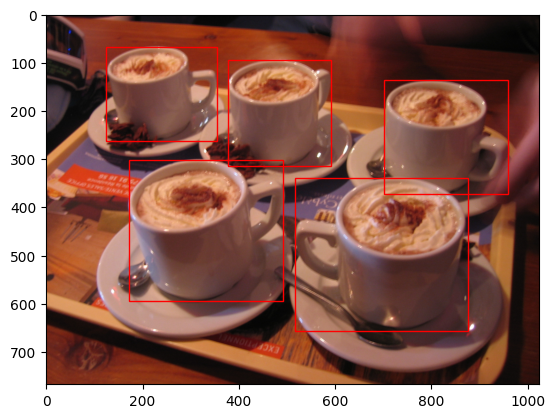

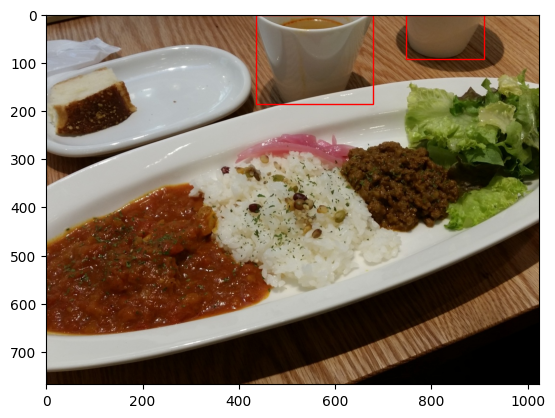

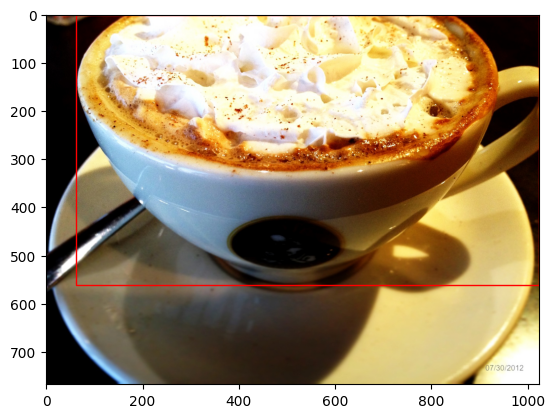

In [ ]:
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to plot image with bounding boxes
def plot_image_with_bboxes(image_path, bboxes):
    # Open the image
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Get image dimensions
    width, height = img.size

    # Plot each bounding box
    for bbox in bboxes:
        xmin, xmax, ymin, ymax = bbox
        # Convert from percent to pixels
        xmin *= width
        xmax *= width
        ymin *= height
        ymax *= height
        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

# Plot all images with bounding boxes
for image_path, bboxes in merged_bboxes[:5]:
    plot_image_with_bboxes(image_path, bboxes)

In [53]:
%pip install azure-cognitiveservices-vision-customvision
%pip install python-dotenv
%pip install msrest


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Retrieve keys and endpoint from environment variables
training_key = os.getenv('TRAINING_KEY')
prediction_key = os.getenv('PREDICTION_KEY')
endpoint = os.getenv('ENDPOINT')
project_id = os.getenv('PROJECT_ID')
publish_iteration_name = os.getenv('PUBLISH_ITERATION_NAME')

# Authenticate with the training and prediction clients
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(endpoint, credentials)


In [61]:
# Create a dictionary to hold the tag IDs for each class
tag_ids = {}

# Iterate over the classes dataframe and create a tag for each class
for _, row in classes.iterrows():
    tag_name = row['LabelDisplayName']
    tag = trainer.create_tag(project_id, tag_name)
    tag_ids[tag_name] = tag.id

tag_ids

{'Coffee cup': '6d51277a-f3a1-4885-8018-de546bd3b71c'}

In [67]:
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, ImageFileCreateBatch, Region

# Add images to the project
tagged_images_with_regions = []

for image_path, bboxes in merged_bboxes:
    regions = []
    for bbox in bboxes:
        xmin, xmax, ymin, ymax = bbox
        regions.append(Region(tag_id=tag_ids[TargetLabel], left=xmin, top=ymin, width=xmax - xmin, height=ymax - ymin))
    
    with open(image_path, "rb") as image_contents:
        tagged_images_with_regions.append(ImageFileCreateEntry(name=os.path.basename(image_path), contents=image_contents.read(), regions=regions))

upload_result = trainer.create_images_from_files(project_id, ImageFileCreateBatch(images=tagged_images_with_regions))
if not upload_result.is_batch_successful:
    print("Image batch upload failed.")
    for image in upload_result.images:
        print("Image status: ", image.status)
    exit(-1)